# Slow Feature Analysis (SFA)
**Slow Feature Analysis (SFA)** とは, 複数の時系列データの中から低速に変化する成分 (slow feature) を抽出する教師なし学習のアルゴリズムである \citep{Wiskott2002-vb,Wiskott2011-uz}．潜在変数 $y$ の時間変化の2乗である $\left(\frac{dy}{dt}\right)^2$を最小にするように教師なし学習を行う．初期視覚野の受容野 \citep{Berkes2005-i} や格子細胞・場所細胞などのモデルに応用がされている \citep{Franzius2007-sf}．

生理学的妥当性についてはいくつかの検討がされている．\citep{Sprekeler2007-qm} ではSTDP則によりSFAが実現できることを報告している．古典的な線形Recurrent neural networkでの実装も提案されている \citep{Lipshutz2020-uj}．

まずデータセットの生成を行う．\citep{Wiskott2002-vb}で用いられているトイデータを用いる．

In [1]:
using PyPlot, Statistics, LinearAlgebra
rc("axes.spines", top=false, right=false)

In [2]:
# create the input signal
nt = 5000;
t = range(0, 2π, length=nt)

x1 = sin.(t) + 2*cos.(11*t).^2;
x2 = cos.(11*t);

X = [x1 x2];

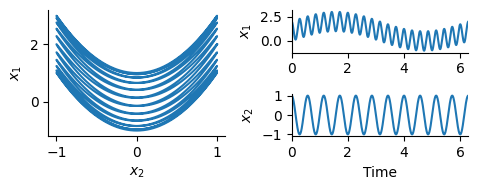

In [3]:
figure(figsize=(5, 2))
subplot2grid((2, 2), (0, 0), rowspan=2)
plot(x2, x1)
xlabel(L"$x_2$"); ylabel(L"$x_1$")
subplot2grid((2, 2), (0, 1))
plot(t, x1)
ylabel(L"$x_1$"); xlim(0, 2π)
subplot2grid((2, 2), (1, 1))
plot(t, x2)
xlabel("Time"); ylabel(L"$x_2$"); xlim(0, 2π)
tight_layout()

SFAの前処理として多項式展開(polynomial expandsion)が用いられる．

In [4]:
monomials(n, d) = [t for t in Base.product(ntuple(i->0:d, Val{n}())...) if sum(t)<=d && sum(t) > 0]
polynomial_expand(X, d) =  hcat([[prod(X[i, :] .^ m) for m in monomials(size(X)[2], d)] for i in 1:size(X)[1]]...)'
whiten(X) = (X .- mean(X, dims=1)) ./ std(X, dims=1);

whiten (generic function with 1 method)

時間的にずらして時系列データの次元を増やす前処理も行われる．

In [5]:
time_frames(X, d) = hcat([X[i:end-d+i] for i in 1:d]...);

SFAの実装をする．

In [7]:
# Linear slow feature analysis
function linsfa(X)
    # X ∈ R^(dims x timesteps)
    Xw = whiten(X)
    _, _, V = svd(diff(Xw, dims=1))
    return Xw[1:end-1, :] * V; # V means weight matrix of X to Y
end

linsfa (generic function with 1 method)

実行と結果表示を行う．

In [8]:
Y = linsfa(polynomial_expand(X, 2));

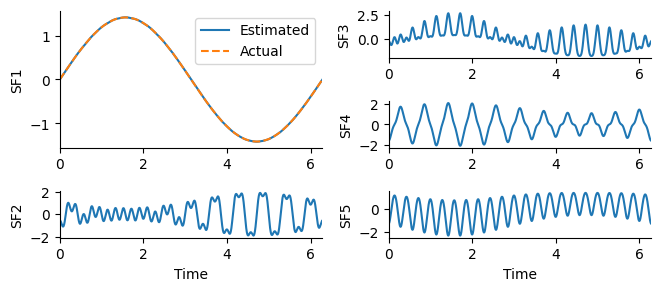

In [11]:
figure(figsize=(10, 3))
subplot2grid((3, 3), (0, 0), rowspan=2)
plot(t[1:end-1], whiten(Y[:, end]), label="Estimated")
plot(t[1:end-1], whiten(sin.(t[1:end-1])), "--", label="Actual")
ylabel("SF1"); xlim(0, 2π); legend(loc="upper right");
for i in 1:4
    if i == 1
        subplot2grid((3, 3), (2, 0))
        xlabel("Time");
    else
        subplot2grid((3, 3), (i-2, 1))
    end
    plot(t[1:end-1], whiten(Y[:, end-i]))
    ylabel("SF$(i+1)"); xlim(0, 2π)
end
xlabel("Time")
tight_layout()